About

Detect 120 different breeds of dogs.  Based on Jeremy Howard's fast.ai [lesson 1](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1-breeds.ipynb)

Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Verify GPU

In [3]:
torch.cuda.set_device(0)

In [4]:
torch.cuda.is_available()

True

Set network size and architecture

In [39]:
#sz = 224
sz = 224
arch = resnet34
bs = 64

Split off cross validation set

In [6]:
PATH = "data/dogbreed/"
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

Load data and create learner

In [40]:
tfms=tfms_from_model(arch, sz)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)

Find ideal learning rate

In [41]:
lrf=learn.lr_find()

 73%|███████▎  | 94/128 [00:01<00:01, 29.45it/s, loss=3.95]


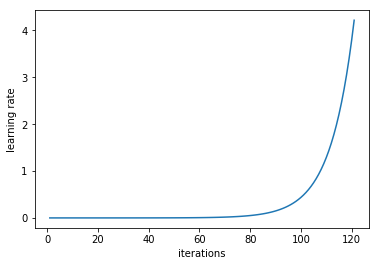

In [42]:
learn.sched.plot_lr()

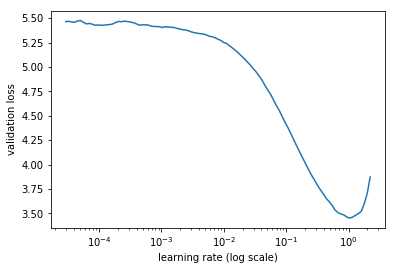

In [43]:
learn.sched.plot()

In [44]:
lr = 1e-1

Initial training run

In [45]:
learn.precompute=True
learn.freeze()
learn.fit(lr, 4)

epoch      trn_loss   val_loss   accuracy                  
    0      1.259075   0.651868   0.794521  
    1      0.768046   0.604414   0.818982                   
    2      0.591086   0.604737   0.81409                    
    3      0.496443   0.602914   0.824364                   



[0.6029137690239923, 0.8243639933386427]

Add data augmentation

In [46]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
learn.fit(lr, 4)

epoch      trn_loss   val_loss   accuracy                   
    0      0.413084   0.606536   0.817515  
    1      0.36463    0.686041   0.809198                   
    2      0.359979   0.681594   0.813601                   
    3      0.341697   0.671234   0.813112                    



[0.6712338776271171, 0.8131115466881171]

Add drop out

In [47]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.fit(lr, 4)

epoch      trn_loss   val_loss   accuracy                   
    0      1.42807    0.715297   0.784736  
    1      0.962621   0.627913   0.803327                  
    2      0.769831   0.562708   0.81409                    
    3      0.669071   0.588343   0.816536                   



[0.5883434465020136, 0.8165362050388657]

Turn off precompute

In [48]:
learn.precompute=False
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.686646   0.559795   0.823386  
    1      0.615285   0.536126   0.834149                    



[0.536125803646976, 0.8341487290341327]

Add SGD with restarts

In [49]:
learn.precompute=False
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.510551   0.513859   0.837573  
    1      0.497568   0.500991   0.835616                    
    2      0.457462   0.493845   0.842955                    



[0.49384461666973134, 0.8429549912650525]

Increase cycle_mult (only if underfitting)

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.367918   2.663904   0.350783  
    1      2.452385   2.670047   0.340998                   
    2      2.276703   2.636022   0.350294                   
    3      2.449946   2.681819   0.347358                   
    4      2.362478   2.659679   0.358611                   
    5      2.228592   2.636344   0.364971                   
    6      2.106607   2.630887   0.358121                   



[2.630886710086681, 0.3581213317738587]

Unfreeze and set learning rate on all layers

In [51]:
learn.unfreeze()
lr=np.array([1e-3,1e-2,1e-1])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.280584   0.818339   0.75      
    1      0.998009   0.899842   0.735323                    
    2      0.46621    0.715628   0.7818                      
    3      0.724922   1.347447   0.636986                    
    4      0.511223   0.979538   0.720646                    
    5      0.229159   0.849594   0.768591                    
    6      0.148826   0.847116   0.768102                    



[0.8471156397211108, 0.7681017620689482]

Add test time augmentation

In [52]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.7734833659491194